# Apprenticeship Learning via IRL - Q Learning

## CartPole-v0

[CartPole-v0 Wiki](https://github.com/openai/gym/wiki/CartPole-v0)

In [1]:
import gym
import numpy as np
from tqdm import tqdm
import imageio
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, Image

In [2]:
env = gym.make('CartPole-v0')

nbins = 10    # discretization
GAMMA = 0.9   # discount factor
ALPHA = 0.01  # learning rate

Observations

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -0.418 rad (-24&deg;) | ~ 0.418 rad (24&deg;)
3 | Pole Velocity At Tip | -Inf | Inf

In [3]:
# Discretize the continuous observable state space

bins = np.zeros((4,nbins))

bins[0] = np.linspace(-2.4, 2.4, nbins)    # position
bins[1] = np.linspace(-5, 5, nbins)        # velocity
bins[2] = np.linspace(-.418, .418, nbins)  # angle
bins[3] = np.linspace(-5, 5, nbins)        # tip velocity

In [4]:
# States

states = []

for i in range (nbins+1):
    for j in range (nbins+1):
        for k in range(nbins+1):
            for l in range(nbins+1):
                a=str(i).zfill(2)+str(j).zfill(2)+str(k).zfill(2)+str(l).zfill(2)
                states.append(a)

In [5]:
# Possible states = (nbins+1)^4

len(states)

14641

Actions:
Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right

In [6]:
# Possible actions

env.action_space.n

2

In [7]:
# Initialize Q Table

def init_Q():
    
    Q = {}
    
    for state in states:
        Q[state] = {}
        
        for action in range(env.action_space.n):
            Q[state][action] = 0
    
    return Q

In [8]:
# Discretize observation into bins

def assign_bins(observation, bins):
    
    discretized_state = np.zeros(4)
    
    for i in range(4):
        discretized_state[i] = np.digitize(observation[i], bins[i])
        
    return discretized_state

In [9]:
# Encode state into string representation as a dictionary

def get_string_state(state):

    string_state = ''.join(str(int(e)).zfill(2) for e in state)
    
    return string_state

In [10]:
# Train an episode

def train_an_episode(bins, Q, epsilon=0.5):
    """
    Simulate one episode of training.

    Parameters:
    - bins: Discretization bins for state representation.
    - Q: Q-table for the reinforcement learning agent.
    - epsilon: Exploration-exploitation trade-off parameter.

    Returns:
    - total_reward: Total reward obtained during the episode.
    - move_count: Number of moves in the episode.
    """
    
    observation = env.reset()
    done = False
    move_count = 0   # no. of moves in an episode
    state = get_string_state(assign_bins(observation, bins))
    total_reward = 0

    while not done:
        move_count += 1

        if np.random.uniform() < epsilon:
            action = env.action_space.sample()  # epsilon-greedy exploration
        else:
            action = max(Q[state].items(), key=lambda x: x[1])[0]   # action with max value

        observation, reward, done, _ = env.step(action)

        total_reward += reward

        # penalize early episode termination
        if done and move_count < 200:
            reward = -300

        new_state = get_string_state(assign_bins(observation, bins))

        best_action, max_q_s1a1 = max(Q[new_state].items(), key=lambda x: x[1])
        Q[state][action] += ALPHA * (reward + GAMMA * max_q_s1a1 - Q[state][action])
        state, action = new_state, best_action

    return total_reward, move_count

In [11]:
# Train for many episodes

def q_learning_train(bins, num_episodes=10000, print_interval=1000):
    """
    Train a Q-learning agent through multiple episodes.
    
    Parameters:
    - bins: Discretization bins for state representation.
    - num_episodes: Number of training episodes.
    - print_interval: Interval for printing training progress.
    
    Returns:
    - episode_lengths: List of lengths for each episode.
    - episode_rewards: List of rewards for each episode.
    - Q: Trained Q-table.
    """
    
    Q = init_Q()
    episode_lengths = []
    episode_rewards = []

    for episode in tqdm(range(1, num_episodes + 1), desc="Training Episodes.."):
        epsilon = 1.0 / np.sqrt(episode + 1)

        episode_reward, episode_length = train_an_episode(bins, Q, epsilon)

        if episode % print_interval == 0:
            print(f"Episode: {episode}, Epsilon: {epsilon:.4f}, Reward: {episode_reward}")

        episode_lengths.append(episode_length)
        episode_rewards.append(episode_reward)

    env.close()
    
    return episode_lengths, episode_rewards, Q

In [12]:
# Plot reward curve

def plot_performance(total_rewards, title='Running Average Reward', save=False, filename='result'):
    """
    Plot the running average of rewards during training.

    Parameters:
    - total_rewards: List of total rewards obtained in each episode during training.
    - title: Title of the plot.
    - save: If True, save the plot as an image file.
    - filename: Name (or path) of the file if saving the plot.

    Returns:
    - None
    """
    
    fig = plt.figure()
    num_episodes = len(total_rewards)
    running_avg = np.empty(num_episodes)

    for episode in range(num_episodes):
        running_avg[episode] = np.mean(total_rewards[max(0, episode - 100):(episode + 1)])

    plt.plot(running_avg)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Running Average Reward")

    if save:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
        plt.show()
    else:
        plt.show()

In [13]:
# simulate env using policy

def run_policy(bins, Q, num_episodes=1000, render=False, render_filename='Agent Policy'):
    """
    Run an environment using a trained policy.

    Parameters:
    - bins: Discretization bins for state representation.
    - Q: Trained Q-table.
    - num_episodes: Number of episodes to run the policy.
    - render: If True, render the environment during execution.
    - render_filename: File name (or path) of gif of the render to be saved if rendering.

    Returns:
    - total_rewards: List of total rewards obtained in each episode.
    """
    
    total_rewards = []

    for episode in tqdm(range(num_episodes), desc='Running Policy...'):
        observation = env.reset()
        done = False
        episode_reward = 0

        images = []
        while not done:
            if render:
                img = env.render(mode='rgb_array')
                images.append(img)

            state = get_string_state(assign_bins(observation, bins))
            action = max(Q[state].items(), key=lambda x: x[1])[0]
            observation, reward, done, _ = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)

    if render:
        imageio.mimsave(f'{render_filename}.gif', images, fps=30, loop=0)
        env.close()
        with open(f'{render_filename}.gif', 'rb') as f:
            display(Image(data=f.read(), format='gif'))

    return total_rewards

## Training - Obtain Expert Policy

* Agent is trained using traditional Q-learning to obtain expert policy for Inverse Reinforcement Learning (IRL).

* Rewards from state-action pairs are stored in a 10000 x 2 array, with rows representing states and columns representing actions. Each cell in the array holds the reward associated with a specific state-action pair.

* The algorithm utilizes an epsilon-greedy approach to choose its actions during training iterations.

* The Q table, which is updated iteratively, represents the policy.

In [14]:
episode_lengths, episode_rewards, expert_Q = q_learning_train(bins,num_episodes=30000, print_interval=2000)

Training Episodes..:   7%|█               | 2038/30000 [00:05<01:10, 399.02it/s]

Episode: 2000, Epsilon: 0.0224, Reward: 154.0


Training Episodes..:  14%|██▏             | 4062/30000 [00:10<01:10, 368.83it/s]

Episode: 4000, Epsilon: 0.0158, Reward: 196.0


Training Episodes..:  20%|███▏            | 6040/30000 [00:17<01:26, 277.74it/s]

Episode: 6000, Epsilon: 0.0129, Reward: 200.0


Training Episodes..:  27%|████▎           | 8042/30000 [00:25<01:16, 285.99it/s]

Episode: 8000, Epsilon: 0.0112, Reward: 198.0


Training Episodes..:  34%|█████          | 10055/30000 [00:32<01:10, 283.35it/s]

Episode: 10000, Epsilon: 0.0100, Reward: 200.0


Training Episodes..:  40%|██████         | 12050/30000 [00:39<01:02, 286.83it/s]

Episode: 12000, Epsilon: 0.0091, Reward: 200.0


Training Episodes..:  47%|███████        | 14048/30000 [00:46<00:58, 274.14it/s]

Episode: 14000, Epsilon: 0.0085, Reward: 200.0


Training Episodes..:  53%|████████       | 16038/30000 [00:54<00:59, 235.12it/s]

Episode: 16000, Epsilon: 0.0079, Reward: 200.0


Training Episodes..:  60%|█████████      | 18030/30000 [01:02<00:57, 209.45it/s]

Episode: 18000, Epsilon: 0.0075, Reward: 200.0


Training Episodes..:  67%|██████████     | 20039/30000 [01:10<00:34, 287.67it/s]

Episode: 20000, Epsilon: 0.0071, Reward: 200.0


Training Episodes..:  74%|███████████    | 22056/30000 [01:18<00:27, 287.81it/s]

Episode: 22000, Epsilon: 0.0067, Reward: 200.0


Training Episodes..:  80%|████████████   | 24035/30000 [01:25<00:20, 297.24it/s]

Episode: 24000, Epsilon: 0.0065, Reward: 200.0


Training Episodes..:  87%|█████████████  | 26055/30000 [01:32<00:13, 294.31it/s]

Episode: 26000, Epsilon: 0.0062, Reward: 200.0


Training Episodes..:  93%|██████████████ | 28042/30000 [01:39<00:07, 277.29it/s]

Episode: 28000, Epsilon: 0.0060, Reward: 200.0


Training Episodes..: 100%|███████████████| 30000/30000 [01:47<00:00, 280.30it/s]

Episode: 30000, Epsilon: 0.0058, Reward: 200.0


In [15]:
# function to save
def save(obj,filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f)
            print(f'Saved {filename}\n')
    except Exception as err:
        print(err)
        
# function to load
def load(filename):
    try:
        with open(filename, 'rb') as file:
            obj = pickle.load(file)
        print(f'Loaded {filename}\n')
        return obj
    except FileNotFoundError as f_err:
        print(f_err)
        return None
    except Exception as e:
        print(e)
        return None

In [16]:
# Save Q table

save(expert_Q, '../Data/Expert_Q_table')

Saved ../Data/Expert_Q_table



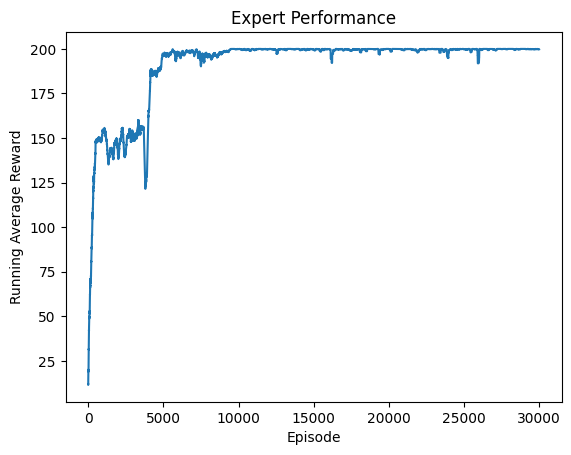

In [17]:
# Plot performance

plot_performance(episode_rewards,title="Expert Performance",save=True,
                 filename='../Results/Q - Learning IRL/Expert Performance')

In [18]:
# Training result
# Using the learned policy, simulate the environment 1000 times to sample the reward distribution.

expert_reward = run_policy(bins, expert_Q, num_episodes=1000, render=False)

Running Policy...: 100%|███████████████████| 1000/1000 [00:03<00:00, 283.63it/s]


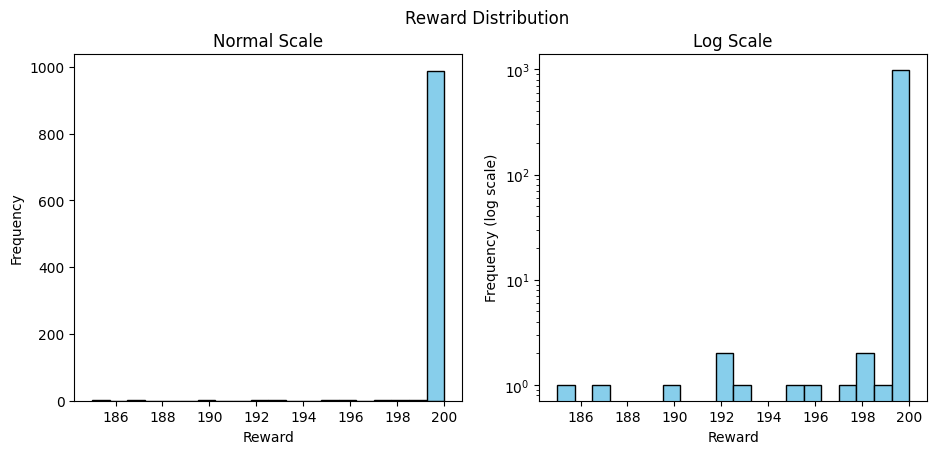

In [19]:
# visualize the reward distribution

def plot_reward_dist(rewards, title='Reward Distribution'):
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

    # histogram
    axes[0].hist(rewards, bins=20, color='skyblue', edgecolor='black')
    axes[0].set_title('Normal Scale')
    axes[0].set_xlabel('Reward')
    axes[0].set_ylabel('Frequency')

    # log-scaled histogram (for skewed distributions)
    axes[1].hist(rewards, bins=20, color='skyblue', edgecolor='black', log=True)
    axes[1].set_title('Log Scale')
    axes[1].set_xlabel('Reward')
    axes[1].set_ylabel('Frequency (log scale)')

    plt.suptitle(title)
    plt.show()

plot_reward_dist(expert_reward)

Running Policy...: 100%|██████████████████████████| 5/5 [00:16<00:00,  3.30s/it]


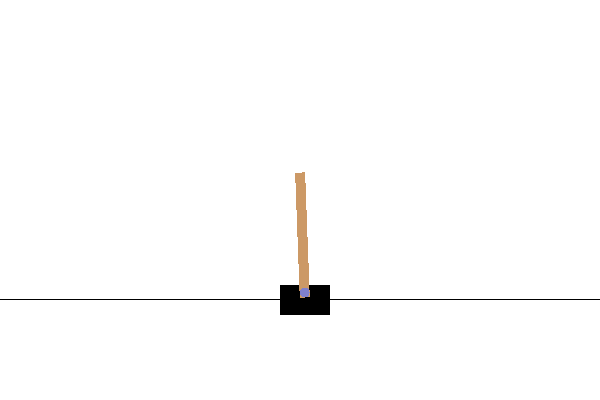

Expert ---> Reward =  [200.0, 200.0, 200.0, 200.0, 200.0]


In [23]:
# Visualize policy in action

expert_reward = run_policy(bins, expert_Q, num_episodes=5, 
                           render=True, render_filename='../Results/Q - Learning IRL/Expert Policy')
print('Expert ---> Reward = ',expert_reward)

# IRL Algorithm

* Some functions are defined for the Apprenticeship Inverse Reinforcement Learning (IRL) algorithm based on the paper by  P. Abbeel and A. Y. Ng titled "Apprenticeship Learning via Inverse Reinforcement Learning."

* To train new agents, a modification is made to the Q-learning algorithm. Instead of utilizing the (predefined) returned reward from the training environment, it incorporates the reward function of the expert derived from the IRL algorithm. This reward function involves a weight term (w) and observation space (Φ(s)) obtained through the IRL algorithm.

* To ensure observation features fall within the [0, 1] range for computing feature expectations, sigmoid function is applied to each element of the feature vector.

In [24]:
# sigmoid function

def sigmoid(array):

    return 1 / (1 + np.exp(-array))

In [25]:
def calculate_feature_expectation(Q, num_episodes=1000, gamma=0.9, bins=bins):
    """
    Calculate the average feature expectation using the provided Q-table and environment.

    Parameters:
    - Q: Q-table representing the policy.
    - num_episodes: Number of episodes for feature calculation.
    - gamma: Discount factor for future rewards.
    - bins: Discretization bins for state representation.

    Returns:
    - feature_expectation: Calculated average feature expectation.
    """
    
    observation_sum = np.zeros(len(bins))

    for _ in range(num_episodes):
        observation = env.reset()
        done = False
        count = 0

        while not done:
            state = get_string_state(assign_bins(observation, bins))
            action = max(Q[state].items(), key=lambda x: x[1])[0]
            observation, reward, done, _ = env.step(action)
            
            # apply sigmoid function to observation features
            observation = sigmoid(observation)

            # accumulate discounted observation features
            observation_sum += (gamma ** count) * observation
            count += 1

    # average feature expectation
    feature_expectation = observation_sum / num_episodes

    print("Feature Expectation:", feature_expectation)
    
    return feature_expectation

In [26]:
def irl_episode(Q, bins, weight, epsilon=0.5):
    """
    Simulate one episode using the IRL-modified Q-learning algorithm.

    Parameters:
    - Q: Q-table representing the policy.
    - bins: Discretization bins for state representation.
    - weight: Weight obtained from the IRL algorithm.
    - epsilon: Exploration-exploitation parameter for epsilon-greedy strategy.

    Returns:
    - total_reward: Total reward obtained in the episode.
    - count: Number of moves in the episode.
    """
    
    observation = env.reset()
    done = False
    count = 0  # no. of moves in an episode
    state = get_string_state(assign_bins(observation, bins))
    total_reward = 0

    while not done:
        count += 1
        # epsilon-greedy strategy
        if np.random.uniform() < epsilon:
            action = env.action_space.sample()
        else:
            action = max(Q[state].items(), key=lambda x: x[1])[0]

        observation, reward, done, _ = env.step(action)

        state_new = get_string_state(assign_bins(observation, bins))

        observation = sigmoid(observation)

        # discard the simulation reward and use the reward function found from the IRL algorithm
        reward = np.dot(weight, observation)     # wT · φ

        total_reward += reward

        if done and count < 200:
            reward = -1

        # Q-learning update
        a1, max_q_s1a1 = max(Q[state_new].items(), key=lambda x: x[1])
        Q[state][action] += ALPHA * (reward + GAMMA * max_q_s1a1 - Q[state][action])
        state, action = state_new, a1

    return total_reward, count

In [27]:
def q_learning_irl(bins, weight, num_episodes=10000):
    """
    Train the policy using the IRL-modified Q-learning algorithm for multiple episodes.

    Parameters:
    - bins: Discretization bins for state representation.
    - weight: Weight obtained from the IRL algorithm.
    - num_episodes: Number of episodes for training.

    Returns:
    - length: List of episode lengths.
    - reward: List of episode rewards.
    - Q: Final Q-table after training.
    """
    
    Q = init_Q()
    episode_lengths = []
    episode_rewards = []

    for n in tqdm(range(num_episodes), desc='Training with IRL..'):
        epsilon = 1.0 / np.sqrt(n + 1)

        episode_reward, episode_length = irl_episode(Q, bins, weight, epsilon)

        episode_lengths.append(episode_length)
        episode_rewards.append(episode_reward)

    avg_length = np.average(episode_lengths)
    std_dev_length = np.std(episode_lengths)
    
    print(f"Avg Length: {avg_length} \nStandard Deviation: {std_dev_length}")

    return episode_lengths, episode_rewards, Q

In [28]:
# get feature expectation of expert

expert_Q = load('../Data/Expert_Q_table')

expert_expectation = calculate_feature_expectation(expert_Q, num_episodes=10000)

Loaded ../Data/Expert_Q_table

Feature Expectation: [3.076376   1.94556355 3.24387236 4.7686564 ]


### IRL algorithm using projection method

In [29]:
# terminate with margin or iteration
epsilon = 0.0001
N = 11

weight = []
feature_expectation = []
feature_expectation_bar = []
learned_Q = []
margin = []
avg_episode_length = []

for i in range(N):
    print("Iteration:", i)
    
    # Step 1: Initialization
    if i == 0:
        initial_Q = init_Q()  # Random initial policy
        feature_expectation.append(calculate_feature_expectation(initial_Q))
        print("Expert Feature Expectation:", expert_expectation)
        learned_Q.append(initial_Q)
        weight.append(np.zeros(4))
        margin.append(1)
        
    else:
        # Step 2: Iterations
        # First iteration of step 2 of algorithm
        if i == 1:
            feature_expectation_bar.append(feature_expectation[i - 1])
            weight.append(expert_expectation - feature_expectation[i - 1])  # w(i) = μE − μ¯(i−1)
            margin.append(np.linalg.norm((expert_expectation - feature_expectation_bar[i - 1]), 2))  #t(i) = ∥µE − µ¯(i−1)∥_2
            print("Margin:", margin[i])
            print("Weight:", weight[i])
            
        # Iterations 2 and onward of step 2 of algorithm
        else:
            A = feature_expectation_bar[i - 2]                          # µ¯(i−2)
            B = feature_expectation[i - 1] - A                          # (µ(i−1) − µ¯(i−2))
            C = expert_expectation - feature_expectation_bar[i - 2]      # µE − µ¯(i−2)
            
            feature_expectation_bar.append(A + (np.dot(B, C) / np.dot(B, B)) * B)
            
            weight.append(expert_expectation - feature_expectation_bar[i - 1])
            margin.append(np.linalg.norm((expert_expectation - feature_expectation_bar[i - 1]), 2))
            print("Margin:", margin[i])
            print("Weight:", weight[i])
            
        # Step 3: Termination condition
        if margin[i] <= epsilon:
            break

        # Step 4: IRL training
        episode_lengths, episode_rewards, learned_Q_i = q_learning_irl(bins, weight[i])
        learned_Q.append(learned_Q_i)
        avg_episode_length.append(episode_lengths)
        
        # Step 5: Update feature expectation
        feature_expectation.append(calculate_feature_expectation(learned_Q[i]))

    print("")

# export trained IRL model
save(learned_Q, '../Data/Learned_Q_tables')

Iteration: 0
Feature Expectation: [3.0596612  1.92163159 3.22883754 4.76493707]
Expert Feature Expectation: [3.076376   1.94556355 3.24387236 4.7686564 ]

Iteration: 1
Margin: 0.03304546786342645
Weight: [0.0167148  0.02393197 0.01503482 0.00371934]


Training with IRL..: 100%|███████████████| 10000/10000 [00:36<00:00, 270.77it/s]


Avg Length: 159.8339 
Standard Deviation: 46.9354014661641
Feature Expectation: [3.06443057 1.94429624 3.23488387 4.74688126]

Iteration: 2
Margin: 0.02505950490687355
Weight: [0.0132883  0.00764881 0.0106909  0.01669132]


Training with IRL..: 100%|███████████████| 10000/10000 [00:29<00:00, 336.91it/s]


Avg Length: 133.8942 
Standard Deviation: 56.629617748665765
Feature Expectation: [3.46248092 2.56373431 3.58776097 4.78804849]

Iteration: 3
Margin: 0.017847020251219047
Weight: [ 0.00475675 -0.0057195   0.00311663  0.01592053]


Training with IRL..: 100%|███████████████| 10000/10000 [00:25<00:00, 390.95it/s]


Avg Length: 113.3082 
Standard Deviation: 34.91836784215436
Feature Expectation: [3.06332792 1.92392194 3.23129662 4.76906656]

Iteration: 4
Margin: 0.014682604281704478
Weight: [0.00721237 0.00238396 0.00591811 0.01108392]


Training with IRL..: 100%|███████████████| 10000/10000 [00:23<00:00, 419.54it/s]


Avg Length: 90.9491 
Standard Deviation: 31.8067871560458
Feature Expectation: [3.05822418 1.92047996 3.22836098 4.76292168]

Iteration: 5
Margin: 0.013893896589805674
Weight: [ 0.00532301 -0.00153651  0.00426125  0.01200778]


Training with IRL..: 100%|███████████████| 10000/10000 [00:39<00:00, 252.27it/s]


Avg Length: 148.1529 
Standard Deviation: 45.45195179076472
Feature Expectation: [3.0859659  1.9705132  3.25207884 4.75510291]

Iteration: 6
Margin: 0.013656188152480509
Weight: [ 0.00407051 -0.00350292  0.00321411  0.0121376 ]


Training with IRL..: 100%|███████████████| 10000/10000 [00:32<00:00, 306.09it/s]


Avg Length: 125.2078 
Standard Deviation: 22.707611480734826
Feature Expectation: [3.07018976 1.94010609 3.24013456 4.76630988]

Iteration: 7
Margin: 0.008845980349101853
Weight: [0.00570706 0.00342808 0.0036192  0.00456404]


Training with IRL..: 100%|███████████████| 10000/10000 [00:39<00:00, 250.31it/s]


Avg Length: 172.1582 
Standard Deviation: 56.58275861744459
Feature Expectation: [3.45978304 2.56080783 3.58467873 4.78056016]

Iteration: 8
Margin: 0.005398205517633878
Weight: [ 0.00233274 -0.00193693  0.0006324   0.00442124]


Training with IRL..: 100%|███████████████| 10000/10000 [00:40<00:00, 248.17it/s]


Avg Length: 146.6877 
Standard Deviation: 35.45842309959652
Feature Expectation: [3.07927129 1.95013034 3.24586845 4.76896909]

Iteration: 9
Margin: 0.0039076770112825765
Weight: [-0.0001094  -0.0031654  -0.00059543  0.00220991]


Training with IRL..: 100%|███████████████| 10000/10000 [00:40<00:00, 245.08it/s]


Avg Length: 150.5331 
Standard Deviation: 42.40904979352874
Feature Expectation: [3.0731799  1.94911654 3.24234405 4.76006241]

Iteration: 10
Margin: 0.0034546173978797167
Weight: [-0.00091366 -0.00307109 -0.00111216  0.00065659]


Training with IRL..: 100%|███████████████| 10000/10000 [00:43<00:00, 230.00it/s]


Avg Length: 163.9944 
Standard Deviation: 52.815669726322696
Feature Expectation: [3.4465617  2.53754664 3.57364342 4.78246078]

Saved ../Data/Learned_Q_tables



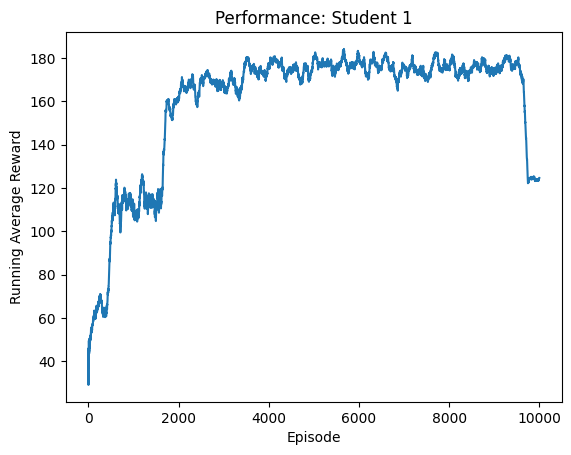

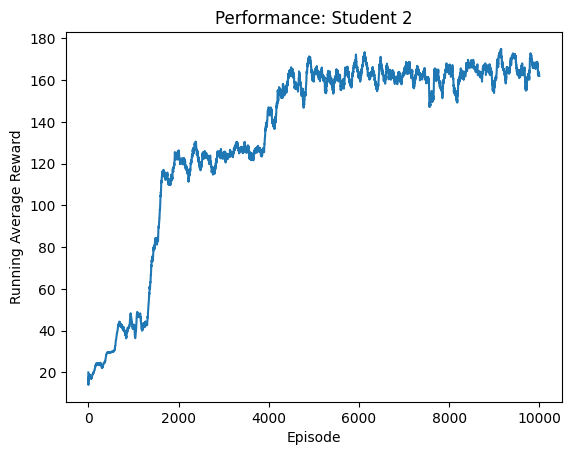

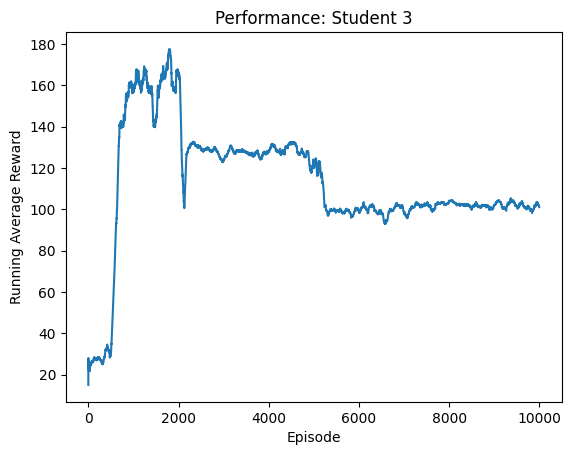

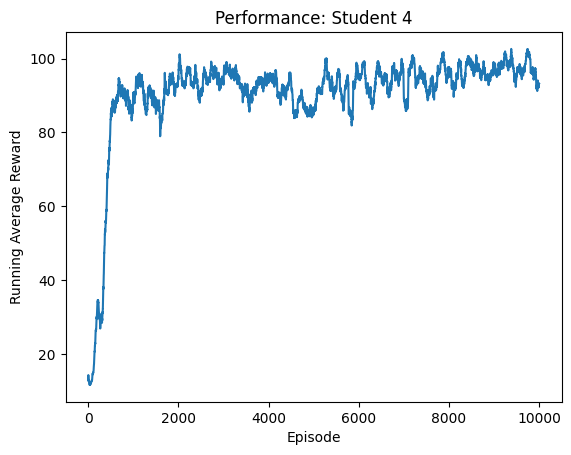

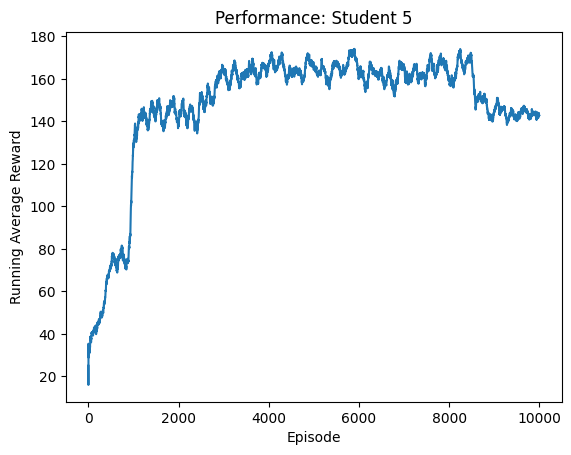

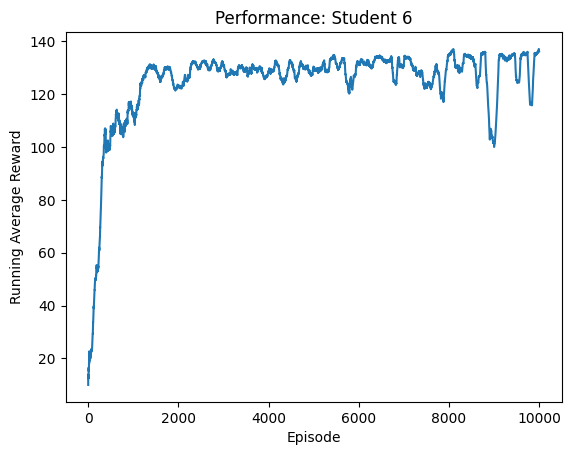

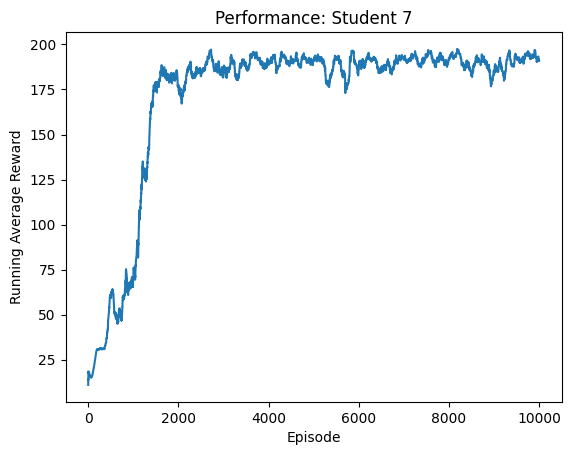

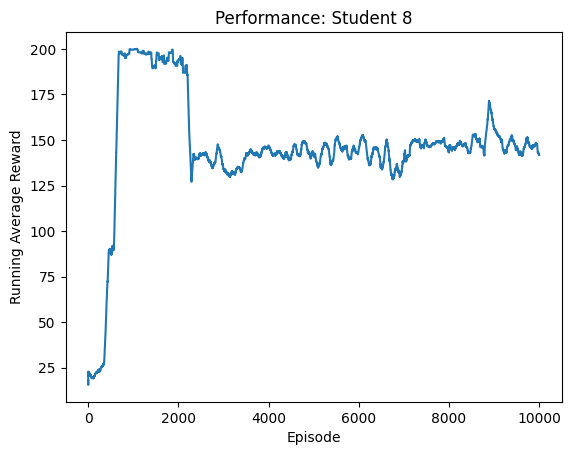

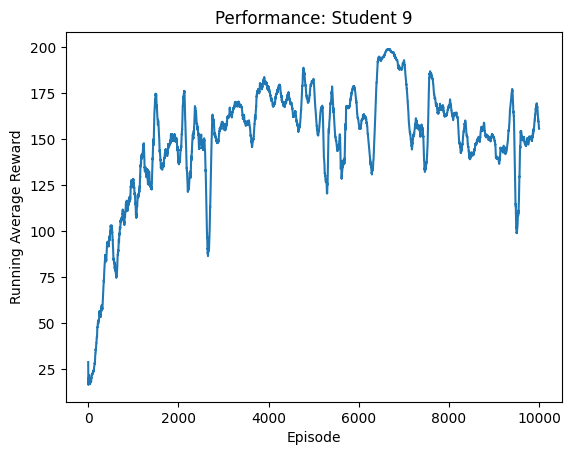

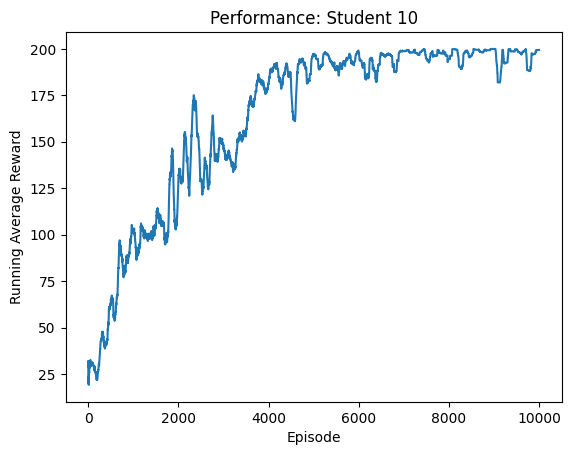

In [36]:
# performance of each student
    
for i in range(len(avg_episode_length)):
    student_title = f"Performance: Student {i + 1}"
    plot_performance(avg_episode_length[i], title=student_title, save=True, 
                     filename=f"../Results/Q - Learning IRL/Student_{i + 1}_Performance")

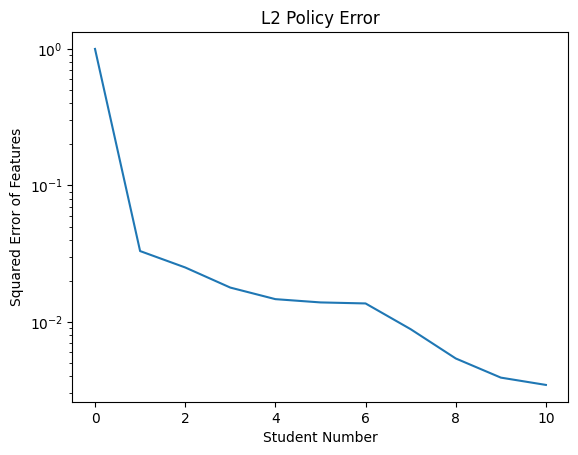

In [37]:
# Plotting Convergence Rate

plt.plot(margin)
plt.title("L2 Policy Error")
plt.xlabel("Student Number")
plt.ylabel("Squared Error of Features")
plt.yscale("log")
plt.savefig("../Results/Q - Learning IRL/Students Policy Error.png")
plt.show()

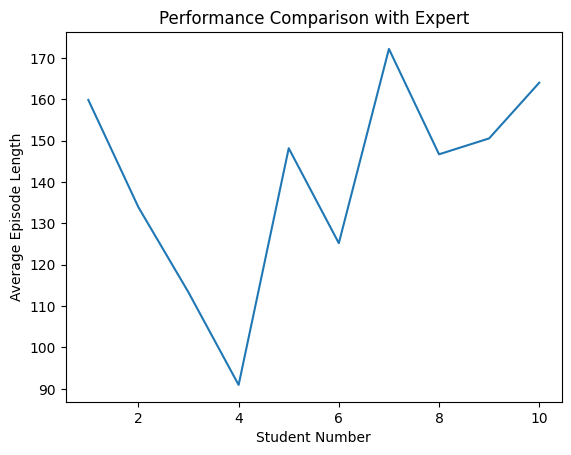

In [38]:
# Showing the performance of each student relative to the expert

iteration = []
relative_performance = []
student_performance = []

# average performance for each student
for episode_lengths in avg_episode_length:
    student_performance.append(np.average(episode_lengths))

for i, performance in enumerate(student_performance):
    iteration.append(i + 1)
    relative_performance.append(performance)

plt.plot(iteration, relative_performance)
plt.xlabel("Student Number")
plt.ylabel("Average Episode Length")
plt.title("Performance Comparison with Expert")
plt.savefig("../Results/Q - Learning IRL/Student Rewards.png")
plt.show()

Running Policy...: 100%|██████████████████████████| 5/5 [00:10<00:00,  2.05s/it]


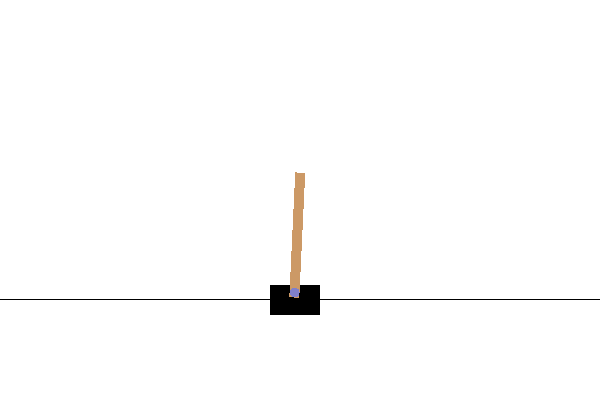

Student 1 -  [124.0, 114.0, 132.0, 131.0, 120.0]


Running Policy...: 100%|██████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


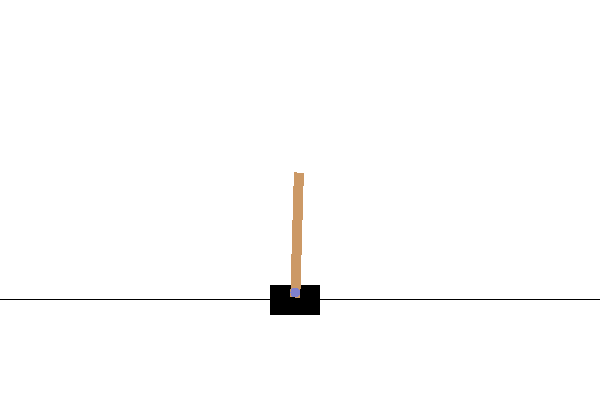

Student 2 -  [189.0, 146.0, 187.0, 197.0, 76.0]


Running Policy...: 100%|██████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


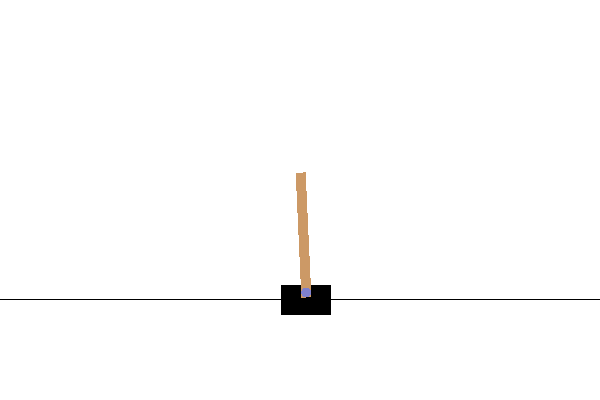

Student 3 -  [99.0, 87.0, 96.0, 96.0, 108.0]


Running Policy...: 100%|██████████████████████████| 5/5 [00:08<00:00,  1.78s/it]


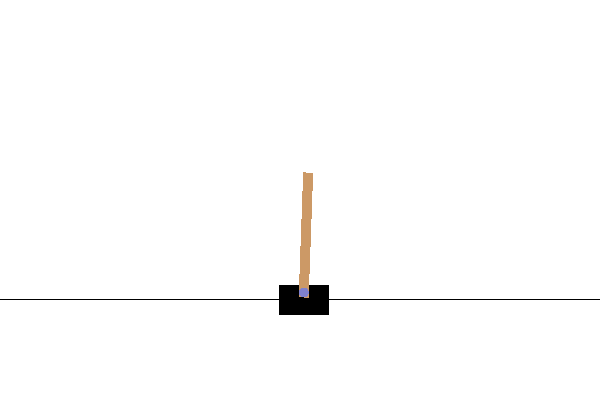

Student 4 -  [108.0, 106.0, 106.0, 110.0, 106.0]


Running Policy...: 100%|██████████████████████████| 5/5 [00:12<00:00,  2.45s/it]


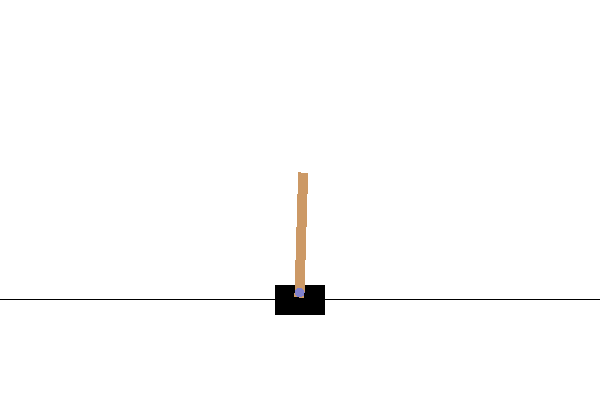

Student 5 -  [186.0, 137.0, 120.0, 176.0, 124.0]


Running Policy...: 100%|██████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


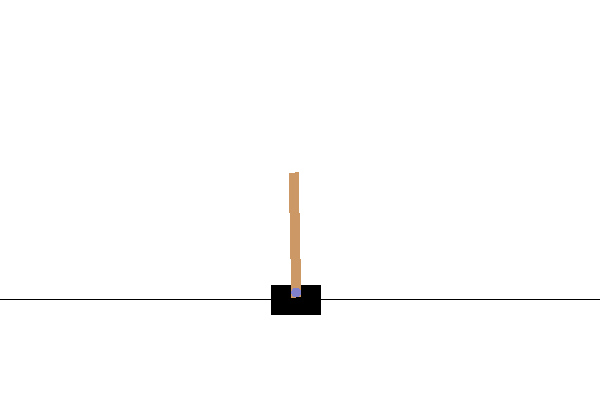

Student 6 -  [140.0, 135.0, 137.0, 122.0, 145.0]


Running Policy...: 100%|██████████████████████████| 5/5 [00:16<00:00,  3.30s/it]


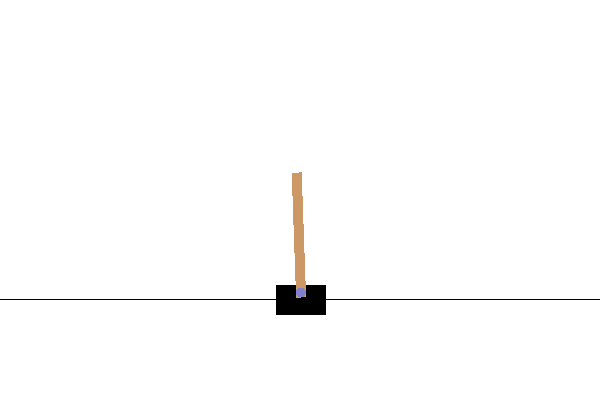

Student 7 -  [200.0, 200.0, 200.0, 200.0, 200.0]


Running Policy...: 100%|██████████████████████████| 5/5 [00:10<00:00,  2.16s/it]


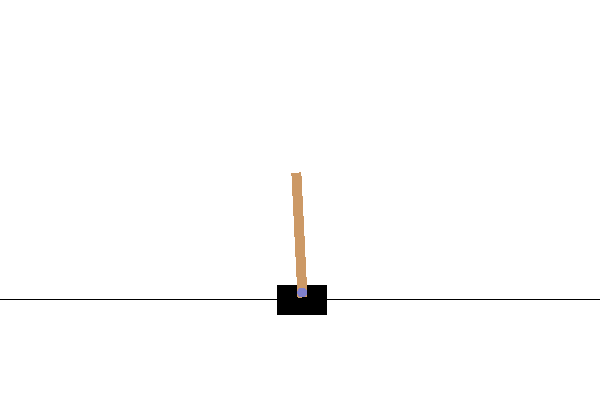

Student 8 -  [118.0, 128.0, 128.0, 136.0, 140.0]


Running Policy...: 100%|██████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


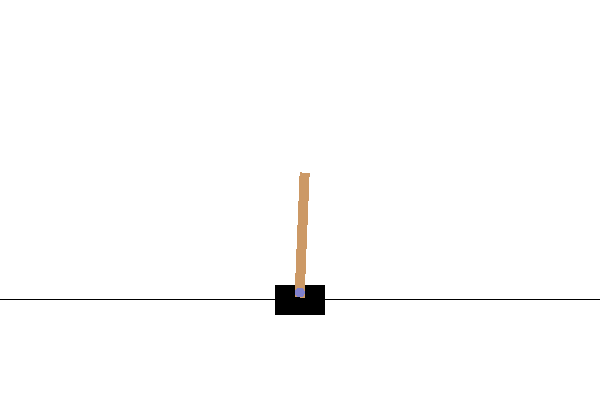

Student 9 -  [139.0, 140.0, 150.0, 154.0, 139.0]


Running Policy...: 100%|██████████████████████████| 5/5 [00:16<00:00,  3.31s/it]


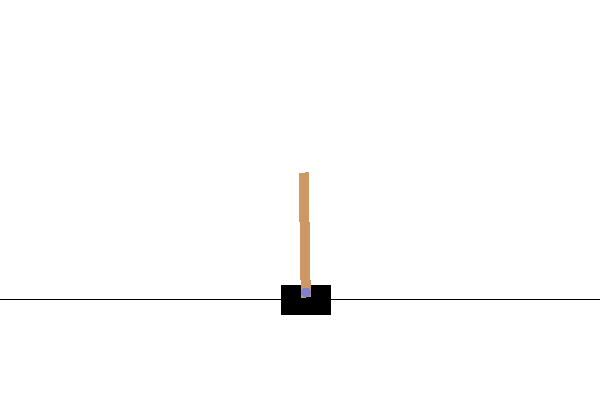

Student 10 -  [200.0, 200.0, 200.0, 200.0, 200.0]


In [41]:
for student in range(1, len(avg_episode_length)+1):
    student_reward = run_policy(bins, learned_Q[student], num_episodes=5, 
                           render=True, render_filename=f'../Results/Q - Learning IRL/Student {student} Policy')
    print(f'Student {student} - ', student_reward)